In [1]:
# Copy for plotting

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import compress
import time

from sklearn.linear_model import lasso_path, enet_path, LogisticRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE, SequentialFeatureSelector, SelectFromModel
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, r_regression

import scipy.stats as ss

from helpers import expr_data
from helpers import scale_data
from helpers import similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# import random
# np.random.seed(47906)
# random.seed(15231)

In [4]:
import random
np.random.seed(42)
random.seed(42)

In [5]:
SKU='cpu4'

## Load all data

In [6]:
data = expr_data.ExprData()
data.load_pickle()
# data = data.remove_by_wlname(['xml'])
data = data.fix_tpch()
# data = data.sample_data()

#### Split by SKU

In [7]:
data_by_sku = data.split_by_sku()
curr_data = data_by_sku[SKU]

In [8]:
print(list(zip(curr_data.terminal_num, curr_data.wl_names)))

[(32, 'tpcc'), (32, 'tpcc'), (32, 'tpcc'), (8, 'tpcc'), (8, 'tpcc'), (8, 'tpcc'), (4, 'tpcc'), (4, 'tpcc'), (4, 'tpcc'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (1, 'tpch'), (32, 'twitter'), (32, 'twitter'), (32, 'twitter'), (8, 'twitter'), (8, 'twitter'), (8, 'twitter'), (4, 'twitter'), (4, 'twitter'), (4, 'twitter'), (32, 'ycsb'), (4, 'ycsb'), (8, 'ycsb'), (32, 'ycsb'), (4, 'ycsb'), (8, 'ycsb'), (32, 'ycsb'), (4, 'ycsb'), (8, 'ycsb')]


#### Calculate Distance

In [9]:
# the result sku_result is a dict with its key the SKU,
# the value a list, the classification accuracy for each f_num
data_dist = {}

for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    if 'ter' in sku:
        continue
    print(f'cpu_num={sku}')
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    # simi_calc.num_bins=100
    # simi_calc.num_bins=50

    simi_calc.calc_bined_mtx() # all features
    simi_calc.calc_dist_simi_matrix(normalize=True)
    print(simi_calc.simi_mtx.shape)
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col()
    print(simi_calc.simi_col_mtx.shape)
    # calc_col_dist_simi_matrix(normalize=False) # all features
    
    data_dist[sku] = simi_calc

cpu_num=cpu16
(36, 36)
(36, 36, 29)
(36, 36, 29)
cpu_num=cpu2
(36, 36)
(36, 36, 29)
(36, 36, 29)
cpu_num=cpu4
(36, 36)
(36, 36, 29)
(36, 36, 29)
cpu_num=cpu8
(36, 36)
(36, 36, 29)
(36, 36, 29)


## Select Top K Features

In [10]:
# return non-zero index in descending order
def sparse_argsort(arr):
    arr = np.where(np.isnan(arr), 0, arr)
    arr = arr * -1
    indices = np.nonzero(arr)[0]
    result = indices[np.argsort(arr[indices])]
    return result

def all_argsort(arr):
    arr = np.where(np.isnan(arr), 0, arr)
    arr = arr * -1
    result = np.argsort(arr)
    return result

### Filter Based

#### Variance threshold

In [11]:
def variance_threshold(X, y):
    selector = VarianceThreshold()
    selector.fit(X)
    scores = selector.variances_
    return sparse_argsort(scores)

#### fANOVA, Chi-Squared test, Mutual Information gain, Fisher score

In [12]:
# fANOVA, Chi-Squared test, Mutual Information gain, Fisher score
def select_k_best(X, y, method):
    if method == 'fANOVA':
        selector = SelectKBest(f_classif, k='all')
    elif method == 'Chi2':
        selector = SelectKBest(chi2, k='all')
    elif method == 'MutualInfoGain': # this uses knn=3 by default to do the feature selection 
        selector = SelectKBest(mutual_info_classif, k='all')  
    elif method == 'Pearson': #https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.htm
        selector = SelectKBest(r_regression, k='all')  
    selector.fit(X, y)
    scores = np.absolute(selector.scores_)
    return sparse_argsort(scores)

In [13]:
# divide by zero; not using this
def fisher_orders(X, y):
    ranks = fisher_score.fisher_score(X, y, mode='rank')
    # ranks are: 1 for most important
    scores = -1 * ranks
    return sparse_argsort(scores)

### Wrapper method

#### RFE (Recursive feature elimination)

In [14]:
def get_est(est_name):
    if est_name == 'DecisionTree':
        estimator = DecisionTreeClassifier(criterion='entropy', max_depth=None)
    elif est_name == 'LogisticRegression':
        estimator = LogisticRegression(n_jobs=4, C=0.01) # C, tol, 
    else: # est_name == 'Linear':
        estimator = SVR(kernel="linear", C=0.05, ) # kernel, degree, 
    return estimator

In [15]:
# create customize base estimator: https://stackoverflow.com/questions/51679173/using-sklearn-rfe-with-an-estimator-from-another-package
def rfe_orders(X, y, est_name):
    estimator = get_est(est_name)
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    # ranks are: 1 for most important
    scores = -1 * selector.ranking_
    return sparse_argsort(scores)

#### SFS (Sequential Feature Selection)

In [16]:
def sfs_orders(curr_data, direction, est_name, n):
    num_features = len(curr_data.feature_cols)
    feature_importance = np.array([0]*num_features)
    
    for i in range(expr_num):
        # calculate label
        curr_name = curr_data.wl_names[i]
        y = [curr_name == name for name in curr_data.wl_names]
        X = simi_calc.simi_col_mtx[i]
        estimator = get_est(est_name)

        selector = SequentialFeatureSelector(estimator, direction=direction.lower(), n_features_to_select=n, n_jobs=-1, cv=3)
        selector = selector.fit(X, y)
        mask = selector.get_support()
        for idx in range(num_features):
            feature_importance[idx] += mask[idx]
    final_orders = sparse_argsort(feature_importance)[:n]
    top_features = [curr_data.feature_cols[j] for j in final_orders]
    return top_features

### Embedded method

#### Lasso

In [17]:
def lasso_weights_orders(X, y):
    selector = Lasso(alpha=0.1).fit(X, y) # C 
    scores = np.abs(selector.coef_)
    return sparse_argsort(scores)

#### Elastic Net

In [18]:
def enet_weights_orders(X, y):
    selector = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X, y)
    scores = np.abs(selector.coef_)
    return sparse_argsort(scores)

### Feature select main function

In [19]:
def get_top_features(curr_data, expr_num, simi_calc, method, note=None):

    # create dict for all features
    num_features = len(curr_data.feature_cols)
    feature_importance = np.array([0]*num_features)
    
    for i in range(expr_num):
        # calculate label
        curr_name = curr_data.wl_names[i]
        y = [curr_name == name for name in curr_data.wl_names]
        # X = simi_calc.dist_by_col_cube[i]
        X = simi_calc.simi_col_mtx[i]
        
        mask = np.ones(X.shape[0], dtype=bool)  
        X = X[mask]#.reshape(-1, 1)
                
        if method == 'Lasso':
            orders = lasso_weights_orders(X, y)
        elif method == 'ENet':
            orders = enet_weights_orders(X, y)
        elif method == 'Variance':
            orders = variance_threshold(X, y)
        elif method == 'fANOVA':
            orders = select_k_best(X, y, method='fANOVA')
        elif method == 'Chi2':
            orders = select_k_best(X, y, method='Chi2')
        elif method == 'MutualInfoGain':
            orders = select_k_best(X, y, method='MutualInfoGain')
        elif method == 'Pearson':
            orders = select_k_best(X, y, method='Pearson')
        elif method == 'Fisher':
            orders = fisher_orders(X, y)
        elif method == 'RFE':
            orders = rfe_orders(X, y, note)

        for idx in range(len(orders)):
            # from 0 to last idx of orders
            # the score = num_features - idx
            #   for a entry with feature_idx important order idx idx
            # the higher the order, the more the score
            feature_importance[orders[idx]] += num_features-idx
    final_orders = all_argsort(feature_importance)
    top_features = [curr_data.feature_cols[j] for j in final_orders]
    return top_features

## Compare Feature Selection with Similarity Calculation

#### Experiment Setup

In [20]:
main_dict = {}
time_dict = {}

In [21]:
# all_features = data_by_sku[list(data_by_sku.keys())[0]].feature_cols
# feature_num = len(all_features)

# knn_thresholds = [1, 2, 3]
# # fs_method = 'Lasso'
# fs_method = 'MutualInfoGain'
# est_name = 'LogisticRegression'

# simi_method = 'KNN'
# f_nums = [1, 3, 7, 15, feature_num]

In [22]:
all_features = data_by_sku[list(data_by_sku.keys())[0]].feature_cols
feature_num = len(all_features)

knn_thresholds = [1, 2, 3]
direct_methods = ['Variance', 'fANOVA', 'Chi2', 'MutualInfoGain', 'Pearson', 'Lasso', 'ENet']
wrapper_methods = ['RFE']
estimator_names = ['Linear', 'DecisionTree', 'LogisticRegression']
other_methods = ['SFS', ]
simi_method = 'KNN'

f_nums = [1, 3, 7, 15, feature_num]

In [23]:
for knn_threshold in knn_thresholds:
    print(knn_threshold)
    
    if knn_threshold not in main_dict:
        main_dict[knn_threshold] = {}
        time_dict[knn_threshold] = {}
    for fs_method in direct_methods:
        print(fs_method)
        curr_method = {}

        for f_num in f_nums:
            curr_method[f_num] = []
        elapsed = []
        for sku in data_by_sku.keys():    
            if 'ter' in sku:
                continue
            curr_data = data_by_sku[sku]
            curr_calc = data_dist[sku]
            expr_num = curr_data.get_num_exprs()
        
            all_accs = []
            # run 10 times to get the average
            num_repeats = 1
            for i in range(num_repeats):       
                curr_accs = []
                start_time = time.time()
                top_features = get_top_features(curr_data, expr_num, curr_calc, fs_method, None)
                f_features = [top_features[:n] for n in f_nums]
                elapsed.append(time.time() - start_time)

                for f_num, curr_f in zip(f_nums, f_features):
                    curr_calc.calc_dist_simi_matrix(feature_names=curr_f)
                    pen, pens = curr_calc.simi_penalty(n=knn_threshold, dependent=True)

                    acc = 1 - (np.sum(pens)/(len(pens)*10))
                    curr_accs.append(acc)
                all_accs.append(curr_accs)
            all_accs = np.average(np.array(all_accs), axis=0)
            for f_num, acc in zip(f_nums, all_accs):
                curr_method[f_num].append(acc)
        main_dict[knn_threshold][fs_method] = curr_method
        time_dict[knn_threshold][fs_method] = np.mean(elapsed)
        print(np.mean(elapsed))

1
Variance
0.030016839504241943
fANOVA
0.05895119905471802
Chi2
0.08891838788986206
MutualInfoGain
3.0321037769317627
Pearson
0.036140382289886475
Lasso
0.0559350848197937
Ridge
0.053963541984558105
2
Variance
0.0275842547416687
fANOVA
0.053755342960357666
Chi2
0.08059489727020264
MutualInfoGain
2.8628602027893066
Pearson
0.036265790462493896
Lasso
0.06385564804077148
Ridge
0.05963319540023804
3
Variance
0.02704864740371704
fANOVA
0.05466723442077637
Chi2
0.07961231470108032
MutualInfoGain
3.4619653820991516
Pearson
0.054550349712371826
Lasso
0.08403968811035156
Ridge
0.08864635229110718


In [35]:
for knn_threshold in knn_thresholds:
    print(knn_threshold)
    
    if knn_threshold not in main_dict:
        main_dict[knn_threshold] = {}
        time_dict[knn_threshold] = {}

    for fs_method in wrapper_methods:
        for est_name in estimator_names:
            print(fs_method, est_name)
            curr_method = {}

            for f_num in f_nums:
                curr_method[f_num] = []
            elapsed = []
            for sku in data_by_sku.keys():    
                if 'ter' in sku:
                    continue
                curr_data = data_by_sku[sku]
                curr_calc = data_dist[sku]
                expr_num = curr_data.get_num_exprs()

                all_accs = []
                # run 10 times to get the average
                num_repeats = 1
                for i in range(num_repeats):       
                    curr_accs = []
                    start_time = time.time()
                    top_features = get_top_features(curr_data, expr_num, curr_calc, fs_method, est_name)
                    f_features = [top_features[:n] for n in f_nums]
                    elapsed.append(time.time() - start_time)
                    print(elapsed[-1])

                    for f_num, curr_f in zip(f_nums, f_features):
                        curr_calc.calc_dist_simi_matrix(feature_names=curr_f)
                        pen, pens = curr_calc.simi_penalty(n=knn_threshold)

                        acc = 1 - (np.sum(pens)/(len(pens)*10))
                        curr_accs.append(acc)
                    all_accs.append(curr_accs)
                all_accs = np.average(np.array(all_accs), axis=0)
                for f_num, acc in zip(f_nums, all_accs):
                    curr_method[f_num].append(acc)
            main_dict[knn_threshold][f'{fs_method}_{est_name}'] = curr_method
            time_dict[knn_threshold][f'{fs_method}_{est_name}'] = np.mean(elapsed)

1
RFE Linear
1.4076910018920898
1.3218214511871338
1.3424444198608398
1.4607799053192139
RFE DecisionTree
1.4294872283935547
1.2863309383392334
1.4663372039794922
1.4866528511047363
RFE LogisticRegression
2202.8546686172485
1429.9395563602448
1267.3513958454132
1605.4157660007477
2
RFE Linear
1.577477216720581
1.4747202396392822
1.4223926067352295
1.5279591083526611
RFE DecisionTree
1.5578157901763916
1.6007928848266602
1.4851863384246826
1.4613277912139893
RFE LogisticRegression
1720.0470547676086
1693.3222029209137
1723.765719652176
1743.0339455604553
3
RFE Linear
1.4462392330169678
1.4250006675720215
1.2803685665130615
1.315006971359253
RFE DecisionTree
1.2754254341125488
1.2614753246307373
1.3523797988891602
1.4725217819213867
RFE LogisticRegression
1761.4656670093536
1786.9737508296967
1583.8809583187103
1627.8937289714813


In [25]:
# for key, val in main_dict.items():
#     print(f'k = {key}')
#     for subk, subval in val.items():
#         print(f'method = {subk}')
#         for fnum, subsubval in subval.items():
#             print(fnum, subsubval)

In [26]:
def pretty_print_table(k=3, sku=None):
    name_trans_dict = {
        'Forward_SFS_Linear': 'Fw SFS Linear',
        'Backward_SFS_Linear': 'Bw SFS Linear',
        'Forward_SFS_DecisionTree': 'Fw SFS DecTree',
        'Backward_SFS_DecisionTree': 'Bw SFS DecTree',
        'Forward_SFS_LogisticRegression': 'Fw SFS LogReg',
        'Backward_SFS_LogisticRegression': 'Bw SFS LogReg',
        'MutualInfoGain': 'MIGain',
        'RFE_Linear': 'RFE Linear',
        'RFE_DecisionTree': 'RFE DecTree',
        'RFE_LogisticRegression': 'RFE LogReg',
    }
    
    sku_trans_dict = {
        'cpu2': 0,
        'cpu4': 1,
        'cpu8': 2,
        'cpu16': 3,
    }
    
    for method, subval in main_dict[k].items():
        outstr = '\\textcolor{}{'
        print_name = method if method not in name_trans_dict else name_trans_dict[method]
        outstr += print_name
        outstr += '} & '
        for fnum, subsubval in subval.items():
            if fnum == 29:
                continue
            if sku is None:
                outstr += f'{np.mean(subsubval):.3f} & '
            else:
                outstr += f'{subsubval[sku_trans_dict[sku]]:.3f} & '
        if method == 'Variance':
            if sku is None:
                all_acc = np.mean(subval[29])
            else:
                all_acc = subval[29][sku_trans_dict[sku]]
            outstr += '\multirow{17}{*}{'
            outstr += '{:.3f}'.format(all_acc)
            outstr += '}'
        outstr += f' & {time_dict[k][method]:.3f} \\\\'
        print(outstr)

In [36]:
for k in [1,2,3]:
    print(k, "-----overall-----")
    pretty_print_table(k=k)
    for sku in [f'cpu{num}' for num in [2, 4, 8, 16]]:
        print(f"-----{sku}-----")
        pretty_print_table(k=k, sku=sku)

1 -----overall-----
\textcolor{}{Variance} & 0.307 & 0.702 & 0.997 & 0.997 & \multirow{17}{*}{0.997} & 0.030 \\
\textcolor{}{fANOVA} & 0.961 & 0.969 & 0.978 & 0.988 &  & 0.059 \\
\textcolor{}{Chi2} & 0.545 & 0.904 & 0.969 & 0.997 &  & 0.089 \\
\textcolor{}{MIGain} & 0.964 & 0.963 & 0.990 & 0.991 &  & 3.032 \\
\textcolor{}{Pearson} & 0.961 & 0.969 & 0.978 & 0.990 &  & 0.036 \\
\textcolor{}{Lasso} & 0.961 & 0.963 & 0.976 & 0.997 &  & 0.056 \\
\textcolor{}{Ridge} & 0.940 & 0.987 & 0.994 & 0.994 &  & 0.054 \\
\textcolor{}{RFE Linear} & 0.961 & 0.970 & 0.990 & 0.992 &  & 1.383 \\
\textcolor{}{RFE DecTree} & 0.248 & 0.969 & 0.997 & 0.997 &  & 1.417 \\
\textcolor{}{RFE LogReg} & 0.789 & 0.965 & 0.993 & 0.997 &  & 1626.390 \\
-----cpu2-----
\textcolor{}{Variance} & 0.483 & 0.717 & 0.997 & 0.997 & \multirow{17}{*}{0.994} & 0.030 \\
\textcolor{}{fANOVA} & 0.969 & 0.983 & 0.986 & 0.989 &  & 0.059 \\
\textcolor{}{Chi2} & 0.483 & 0.969 & 0.989 & 0.997 &  & 0.089 \\
\textcolor{}{MIGain} & 0.981 & 0.

#### Present Results

In [32]:
fs_method = 'Chi2'
# direct_methods = ['Variance', 'fANOVA', 'Chi2', 'MutualInfoGain', 'Pearson', 'Lasso', 'Ridge']

In [33]:
def plot_bar(knn_threshold):
    # colors = sns.color_palette("hls", len(f_nums))
    colors = sns.color_palette("colorblind", len(f_nums))
    markers = ['o', 'D', 'P', 'X', '*', '>', 'p', ]
    # for each # feature (row in df), plot the accuracy for each sku
    X_lab = list(data_by_sku.keys())
    X_lab = [e for e in X_lab if 'ter' not in e]

    X_lab = X_lab[1:]+X_lab[:1]
    print(X_lab)
    X = [1, 2, 3, 4]

    x = np.arange(len(X_lab))  # the label locations
    width = 0.125  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(4.8,3), constrained_layout=True)

    for feature_num, accs in main_dict[knn_threshold][fs_method].items():
        offset = width * multiplier
        if feature_num > 1:
            rects = ax.bar(x + offset, accs, width, label=f'{feature_num} Features', color=colors[multiplier], edgecolor='black')
        else:
            rects = ax.bar(x + offset, accs, width, label=f'{feature_num} Feature', color=colors[multiplier], edgecolor='black')

        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Classification Accuracy')
    ax.set_xlabel('SKU')
    # ax.set_yscale('log')

    # ax.set_title('Feature Selection by {} With KNN, K={}'.format(fs_method, knn_threshold))
    ax.set_xticks(x + width, X_lab)
    # ax.legend(loc='upper left', ncol=2)
    # ax.legend(loc='upper center', ncol=3)
    ax.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=3, mode='expand')
    ax.set_ylim(0, 1.2)

    plt.savefig('../figs/n_{}_{}fs_{}.pdf'.format(fs_method, knn_threshold, simi_method))
    plt.show()

1
['cpu2', 'cpu4', 'cpu8', 'cpu16']


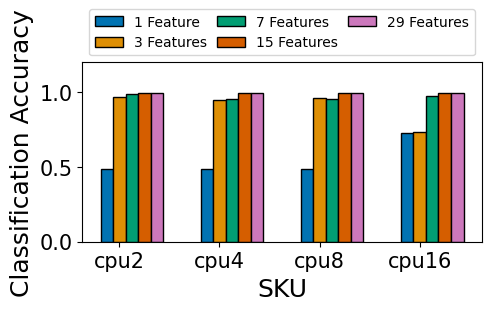

2
['cpu2', 'cpu4', 'cpu8', 'cpu16']


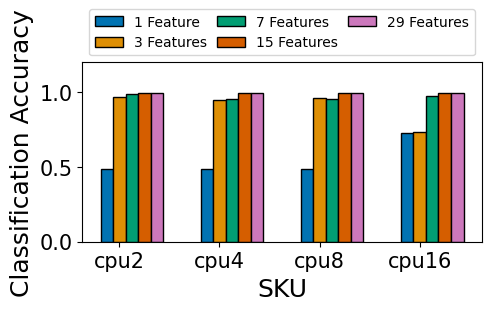

3
['cpu2', 'cpu4', 'cpu8', 'cpu16']


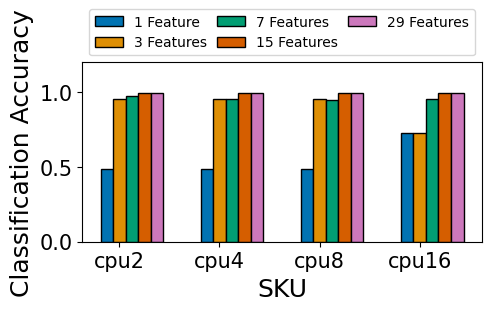

In [34]:
for knn_threshold in knn_thresholds:
    print(knn_threshold)
    plot_bar(knn_threshold)